In [1]:
import numpy  as np
import json
import matplotlib.pylab as plt
import copy
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm import tqdm
import torch
from collections import OrderedDict
from pathlib import Path
import random

In [2]:
damage = 'origin_crack'
path = Path('/mmdetection/data/merimen_coco/06_04_2022/'+damage)
data = json.load(open(path/'annotations'/'clean_crack_v2.json'))
print(len(data['images']),len(data['annotations']))

88512 136964


In [5]:
print(data['categories'])

[{'supercategory': 'Carparts', 'id': 0, 'name': 'crack'}, {'supercategory': 'Carparts', 'id': 1, 'name': 'broken'}]


In [3]:
if damage == 'dent':
    #config_file = '../configs/detectors/dent_detector_latest_segm.py'
    #checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'
    config_file = '../models/cbnet/dent_pseudo/dent_pseudo.py'
    checkpoint_file = '../models/cbnet/dent_pseudo/epoch_30.pth'

if damage == 'loose':
    config_file = '../models/loose/loose.py'
    checkpoint_file = '../models/loose/epoch_9.pth'

if damage == 'combine_crack':
    config_file = '../checkpoints/combine_crack_phase_1/combine_crack.py'
    checkpoint_file = '../checkpoints/combine_crack_phase_1/epoch_28.pth'

if damage == 'origin_crack':
    config_file = '../checkpoints/origin_crack_cp/copy-paste.py'
    checkpoint_file = '../checkpoints/origin_crack_cp/origin_crack_exp_2.pth'
    
if damage == 'scratch':
    config_file = '../checkpoints/scratch_phase_2/scratch_pseudo.py'
    checkpoint_file = '../checkpoints/scratch_phase_2/epoch_29.pth'
    #config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
    #checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'
if damage == 'combine_missing':
    config_file = '../work_dirs/missing/missing.py'
    checkpoint_file = '../work_dirs/missing/epoch_10.pth'

In [4]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [7]:
def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

In [8]:
## single categories

pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.1)

    annos = [[(int(a['bbox'][0]),int(a['bbox'][1])),(int(a['bbox'][0]+a['bbox'][2]),int(a['bbox'][1]+a['bbox'][3]))] 
             for a in data['annotations'] if a['image_id']==img['id']]

    pseudo_segms = []
    check_ol = [True for i in annos]
    
    for i,box in enumerate(pred_boxes):
        ious = [cal_iou(image,box,a) for a,check in zip(annos,check_ol) if check]
        
        if len(ious) == 0 :
            break
            
        idx = np.argmax(ious)
        
        if ious[idx] >= 0.15:
            #print(box)
            pseudo_segms.append(pred_segms[i])
            check_ol[idx] = False
    num_tp += len(pseudo_segms)
    if len(pseudo_segms) == 0:
        continue
        
    pseudo_data['images'].append(img)
    
    for segm in pseudo_segms:
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = 0
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
print('num tp : ',num_tp)
    
with open(path/'annotations'/'post_pseudo.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21788/21788 [44:22<00:00,  8.18it/s]


num tp :  41002


In [43]:
## multi categories

pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.01)

    if len(pred_boxes) == 0:
        continue
        
    annos = [([(int(a['bbox'][0]),int(a['bbox'][1])),(int(a['bbox'][0]+a['bbox'][2]),int(a['bbox'][1]+a['bbox'][3]))],a['category_id']) 
             for a in data['annotations'] if a['image_id']==img['id']]
    
    count_crack_gt = len([a for a in annos if a[1]==0])
    #labels = [a['category_id'] for a in data['annotations'] if a['image_id']==img['id']]

    pseudo_segms = []
    pseudo_labels = []
    check_ol = [True for i in annos]
    
    for i,box in enumerate(pred_boxes):
        ious = [cal_iou(image,box,a[0]) for a,check in zip(annos,check_ol) if check and pred_labels[i]==a[1]]
        
        if len(ious) == 0 :
            break
            
        idx = np.argmax(ious)
        
        if ious[idx] >= 0.15:
            #print(box)
            pseudo_segms.append(pred_segms[i])
            pseudo_labels.append(pred_labels[i])
            check_ol[idx] = False
    
    count_crack_pr = len([l for l in pseudo_labels if l==0])
    
    #print(count_crack_gt,count_crack_pr)
    
    if count_crack_gt != count_crack_pr :
        continue
    
    num_tp += len(pseudo_segms)
    if len(pseudo_segms) == 0:
        continue
        
    pseudo_data['images'].append(img)
    
    for i,segm in enumerate(pseudo_segms):
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = int(pseudo_labels[i])
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
print('num tp : ',num_tp)
    
with open(path/'annotations'/'post_pseudo_check_crack.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88512/88512 [3:15:18<00:00,  7.55it/s]


num tp :  35518


In [47]:
print(len(pseudo_data['images']))

29363


In [44]:
print('racall rate : ',num_tp/len(data['annotations']))

racall rate :  0.2593236178849917


In [10]:
pseudo_data = json.load(open(path/'annotations'/'post_pseudo.json'))
print(len(pseudo_data['images']),len(pseudo_data['annotations']))

19834 42859


In [22]:
def sample(js_data):
    #i = random.choice(js_data['images'])
    num = 2
    imgs = random.sample(js_data['images'],num**2)
    #print(i['id'],i['url'])
    #num = 2 
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,i in enumerate(imgs):
        annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in js_data['annotations'] if a['image_id'] == i['id']]
        print([a['category_id'] for a in js_data['annotations'] if a['image_id']==i['id']])
        image = cv2.imread(str(path/'images'/i['file_name']))
        image = cv2.drawContours(image,annos,-1,(255,0,0),2)
        
        axis[int(idx/num),idx%num].imshow(image)
        axis[int(idx/num),idx%num].set_title(i['id'])
        
    #plt.figure(figsize=(20,10))
    #plt.imshow(image)

[1]
[0]
[0]
[0]


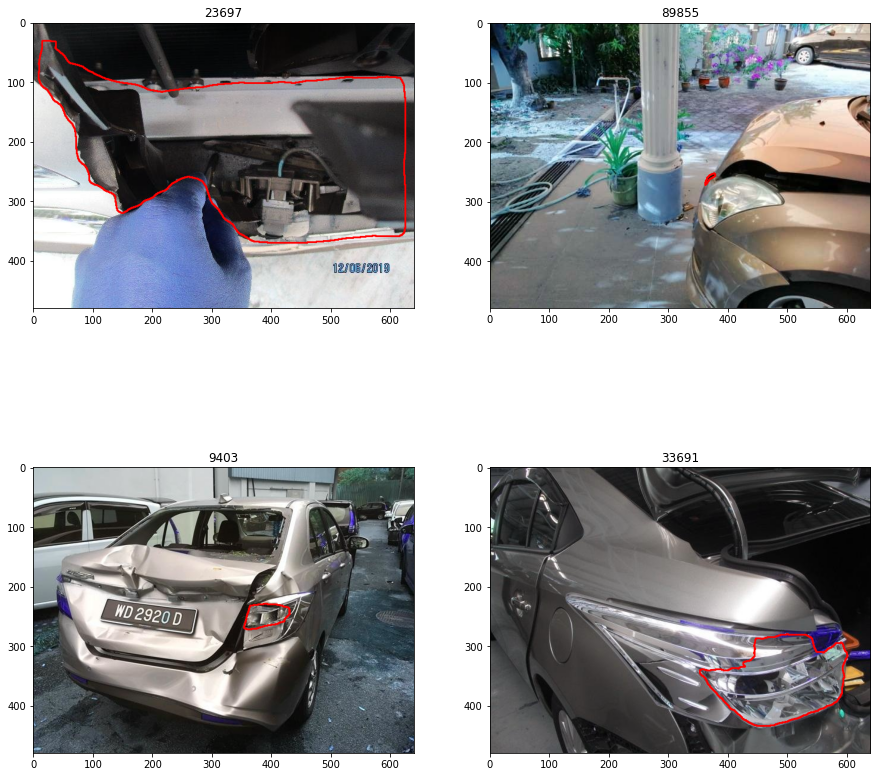

In [40]:
sample(pseudo_data)

In [32]:
pseudo_clean = json.load(open(path/'annotations'/'pseudo_clean_crack_v2.json'))

[0, 0]
[0]
[0]
[1, 1]


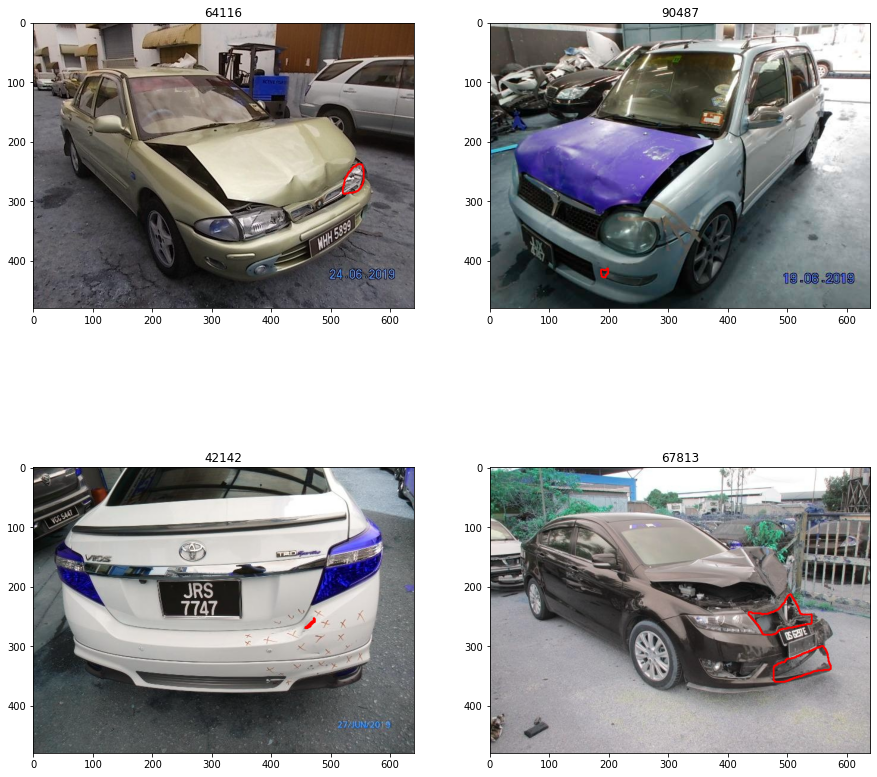

In [35]:
sample(pseudo_clean)

In [65]:
dent : 5559/8458

0.657247576259163

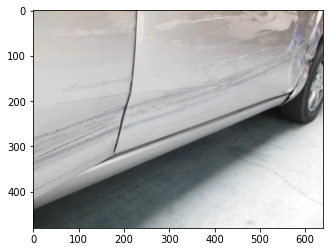

In [8]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))
plt.imshow(image)